## Fitting ID and DD models to CFUs and CEQs ##

*29 Aug 2024*

This code fits ID and DD models to digitized data from 
Figure 2A of Munoz-Elias et al Infection and Immunity 2005. 
The code also generates a plot of the data with model fits.
Rates are calculated analytically, though equivalent results 
could be achieved by minimizing residuals.


In [1]:
#import packages
from math import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

#### Import data ####
To simplify coding, we used two versions of the datafile:

untreatedMice.csv is used for calculating parameters and includes assumed values where CEQs were unvailable.

untreatedMice2.csv is used for adding markers to the plots for individual data points; it only includes measured values.

In [2]:
#Data from Munoz Elias Inf Imm 2005, with assumed values of CEQs added -- used for fitting
df=pd.read_csv('munozEliasFig2aMaxZ.csv')

days=df['days'].values
logCFUs=df['logCFUs'].values
logCEQs=df['logCEQs'].values

#Raw data from Munoz Elias Inf Imm 2005 -- used for plotting points
df2=pd.read_csv('fig2a.csv')
days2=df2['days'].values
logCFUs2=df2['logCFUs'].values
logCEQs2=df2['logCEQs'].values

#### Define functions that return the rates ####

In [3]:
#functions to fit ID and DD models to data (from pairs of B and Q points)
def rID(q0, q, dt, dq):
    return (log(q) - log(q0))/dt + dq

def deltaID(q0, q, b0, b, dt, dq):
    return rID(q0, q, dt, dq) - (log(b) - log(b0))/dt

def rho(b0, b, dt, dd):
    return ((log(b) - log(b0))/dt) + dd

def deltaEff(x0, x, dt, dd):
    return x - x0 * exp(-dd * dt)

def deltaDD(b0, b, q0, q, dt, dd):
    rhotmp = rho(b0, b, dt, dd)
    deltaBeff = deltaEff(b0, b, dt, dd)
    deltaQeff = deltaEff(q0, q, dt, dd)
    return rhotmp * (deltaQeff/deltaBeff - 1)

def rDD(b0, b, q0, q, dt, dd):
    rhotmp = rho(b0, b, dt, dd)
    deltaBeff = deltaEff(b0, b, dt, dd)
    deltaQeff = deltaEff(q0, q, dt, dd)
    return rhotmp * deltaQeff / deltaBeff - dd

#### Calculate rates ####

Loop over time intervals and calculate the replication and death rates. For these calculations, we assume 
the decay rate of detectable genones (deltaD or deltaQ) is 3.6% per day.

In [4]:
#Estimated decay rate of genomes from killed bacteria
deltaD=0.036
deltaQ=0.036

#Use the above function to calculate rates for DD model
ddParams = []
for i in range(len(days)-1):
    b0 = pow(10,logCFUs[i  ])
    b  = pow(10,logCFUs[i+1])
    q0 = pow(10,logCEQs[i  ])
    q  = pow(10,logCEQs[i+1])
    dt = days[i+1] - days[i]
    dd = deltaD
    r     =     rDD(b0, b, q0, q, dt, dd)
    delta = deltaDD(b0, b, q0, q, dt, dd)
    ddParams.append([r, delta, b0, q0])

#Calculate rates for ID model
idParams = []
for i in range(len(days)-1):
    b0 = pow(10,logCFUs[i  ])
    b  = pow(10,logCFUs[i+1])
    q0 = pow(10,logCEQs[i  ])
    q  = pow(10,logCEQs[i+1])
    dt = days[i+1] - days[i]
    dq = deltaQ
    r  = rID(q0, q, dt, dq)
    delta = deltaID(q0, q, b0, b, dt, dq)
    idParams.append([r, delta, b0, q0])

#### Dynamics of CFUs and CEQs ####

Use the integrated forms of the ID and DD models 
for calculating the dynamics of CFUs and CEQs for 
each model.

In [5]:
#Integrated functions for the dynamics of ID model

def bID(t,r,delta,b0):
    return b0 * exp((r-delta)*t)

def qID(t,r,deltaQ,q0):
    return q0 * exp((r-deltaQ)*t)

def zID(t,delta,deltaQ,z0):
    return (b0/q0)*exp(-(delta-deltaQ)*t)

#Integrated functions for the dynamics of the DD model
def d(t,r,delta,b0,q0,deltaD):
    dt = t
    r1 = r - delta + deltaD
    return (delta * b0 / r1) * (exp(r1*dt) - 1) * exp(-deltaD*dt) + (q0-b0) * exp(-deltaD*dt)

def b(t,r,delta,b0):
    dt = t
    return b0 * exp((r - delta) * dt)

def q(t,r,delta,b0,q0,deltaD):
    return d(t,r,delta,b0,q0,deltaD) + b(t,r,delta,b0)

def z(t,r,delta,b0,q0,deltaD):
    return b(t,r,delta,b0)/q(t,r,delta,b0,q0,deltaD)

#### Visualization ####
Generate plots of CFUs and CEQs vs time for the mouse data, and 
for the models.

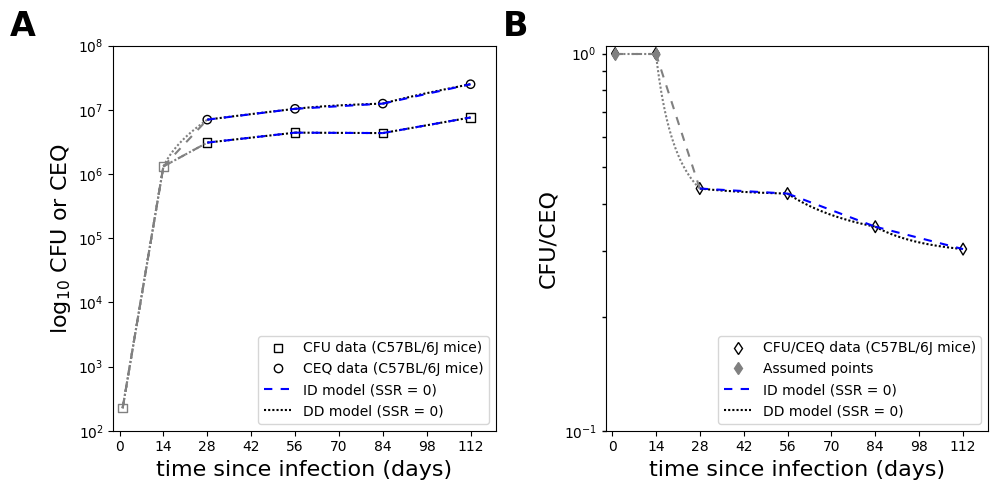

In [6]:
acuteColor='grey'
ddColor='black'
idColor='blue'
fig,ax = plt.subplots(1,2,figsize=(10,5))

labelFontSize=16
#make panel A: B and Q vs t
ceqPoints00=ax[0].scatter(days2[0:2],logCEQs2[0:2],label='CEQ',marker="o",facecolor='none',edgecolor=acuteColor)
cfuPoints00=ax[0].scatter(days2[0:2],logCFUs2[0:2],label='CFU',marker="s",facecolor='none',edgecolor=acuteColor)
ceqPoints00=ax[0].scatter(days2[2:days2.size],logCEQs2[2:days2.size],label='CEQ',marker="o",facecolor='none',edgecolor='black')
cfuPoints00=ax[0].scatter(days2[2:days2.size],logCFUs2[2:days2.size],label='CFU',marker="s",facecolor='none',edgecolor='black')
labelAdjustmentsX=[4,-14,2,0,6]
labelAdjustmentsY=[-.5,-.15,0.15,-0.2,0.1]
for i in range(len(ddParams)):
    xlist=np.linspace(days[i],days[i+1],401)
    r     = ddParams[i][0]
    delta = ddParams[i][1]
    b0    = ddParams[i][2]
    q0    = ddParams[i][3]
    ylist=list()
    if (i > 1):
        lineColor=ddColor
    else:
        lineColor=acuteColor
    for x in xlist:
        ylist.append(log10(q(x-days[i],r,delta,b0,q0,deltaD)))
    ax[0].plot(xlist,ylist,color=lineColor,dashes=[1,1])
    ylist=list()
    for x in xlist:
        ylist.append(log10(b(x-days[i],r,delta,b0)))
    if (i > 1):
        lineColor=ddColor
    else:
        lineColor=acuteColor
    ax[0].plot(xlist,ylist,color=lineColor,dashes=[1,1])
for i in range(len(idParams)):
    xlist=np.linspace(days[i],days[i+1],401)
    r     = idParams[i][0]
    delta = idParams[i][1]
    b0    = idParams[i][2]
    q0    = idParams[i][3]
    ylist=list()
    if (i > 1):
        lineColor=idColor
    else:
        lineColor=acuteColor
    for x in xlist:
        ylist.append(log10(qID(x-days[i],r,deltaQ,q0)))
    ax[0].plot(xlist,ylist,color=lineColor,dashes=[4,4])
    ylist=list()
    for x in xlist:
        ylist.append(log10(bID(x-days[i],r,delta,b0)))
    if (i > 1):
        lineColor=idColor
    else:
        lineColor=acuteColor
    ax[0].plot(xlist,ylist,color=lineColor,dashes=[4,4])
ax[0].set_xlim(-2,120)
ax[0].set_ylim(2,8)
ax[0].set_xlabel("time since infection (days)",fontsize=labelFontSize)
ax[0].set_ylabel("log$_{10}$ CFU or CEQ",fontsize=labelFontSize)
ax[0].set_yticks([2,3,4,5,6,7,8],["$10^2$","$10^3$","$10^4$","$10^5$","$10^6$","$10^7$","$10^8$"])
cfuMarker = mlines.Line2D([], [],color='black',linestyle='None',marker='s',markerfacecolor='None')
ceqMarker = mlines.Line2D([], [],color='black',linestyle='None',marker='o',markerfacecolor='None')
idLine = mlines.Line2D([], [],dashes=[4,4],color=idColor)
ddLine = mlines.Line2D([], [],dashes=[1,1],color=ddColor)
ax[0].legend([cfuMarker,ceqMarker,idLine,ddLine],["CFU data (C57BL/6J mice)", "CEQ data (C57BL/6J mice)","ID model (SSR = 0)","DD model (SSR = 0)"],loc="lower right")
#make panel B: Z vs t
zMarker = "d"
zPoints=ax[1].scatter(df["days"].values,df["CFUs/CEQs"].values,label='CFUs/CEQs',marker=zMarker,facecolor='none',edgecolor='black')
zPointsAssumed=ax[1].scatter(df["days"].values[0:2],df["CFUs/CEQs"].values[0:2],label='Estimates',marker=zMarker,color='grey')
for i in range(len(ddParams)):
    xlist=np.linspace(days[i],days[i+1],401)
    r     = ddParams[i][0]
    delta = ddParams[i][1]
    b0    = ddParams[i][2]
    q0    = ddParams[i][3]
    ylist=list()
    for x in xlist:
        ylist.append(z(x-days[i],r,delta,b0,q0,deltaD))
    if (i > 1):
        lineColor=ddColor
    else:
        lineColor=acuteColor
    ax[1].plot(xlist,ylist,color=lineColor,label='aDD',dashes=[1,1])
for i in range(len(idParams)):
    xlist=np.linspace(days[i],days[i+1],401)
    r     = idParams[i][0]
    delta = idParams[i][1]
    b0    = idParams[i][2]
    q0    = idParams[i][3]
    ylist=list()
    for x in xlist:
        ylist.append(zID(x-days[i],delta,deltaQ,b0/q0))
    if (i > 1):
        lineColor=idColor
    else:
        lineColor=acuteColor
    ax[1].plot(xlist,ylist,color=lineColor,label='aID',dashes=[4,4])
zMarkers = mlines.Line2D([], [],color='black',linestyle='None',marker=zMarker,markerfacecolor='None')
assumedMarker = mlines.Line2D([], [],color='grey',linestyle='None',marker=zMarker)
ax[1].legend([zMarkers,assumedMarker,idLine,ddLine],['CFU/CEQ data (C57BL/6J mice)','Assumed points','ID model (SSR = 0)','DD model (SSR = 0)'],loc='lower right')
ax[1].set_xlabel("time since infection (days)",fontsize=labelFontSize)
ax[1].set_ylabel("CFU/CEQ",fontsize=labelFontSize)
ticks=[0,14,28,42,56,70,84,98,112]
ax[0].set_xticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yscale('log')
ax[1].set_xlim(-2,120)
ax[1].set_ylim(0.1,1.05)
ax[1].tick_params(axis='y', which='both', length=3, width=1)
#mindqdd = 0.001
#maxdqdd = 1.
#shift = 1.3
#ax[0].plot([0.001,0.01],[idMeanDelta(0.),idMeanDelta(0.)],alpha=1,color='blue',lw=1)
#ax[0].plot([0.001,0.01],[ddMeanDelta(0.),ddMeanDelta(0.)],alpha=1,color='black',lw=1)
#xlist=np.logspace(log10(mindqdd),log10(maxdqdd),401)
horizontalOffset = -0.27
verticalOffset = 0.025
abcdFontSize=24
ax[0].annotate("A",(0+horizontalOffset,1+verticalOffset),fontweight='bold',fontsize=abcdFontSize,xycoords='axes fraction')
ax[1].annotate("B",(0+horizontalOffset,1+verticalOffset),fontweight='bold',fontsize=abcdFontSize,xycoords='axes fraction')



plt.tight_layout()
plt.savefig("untreatedMiceModelFits.pdf",format="pdf",bbox_inches='tight')
plt.show()